In [1]:
import os
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F  
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from utils import load, get_audio_path, stereo_to_mono, frequency_mask, time_mask, plot_spectrogram, add_noise, gain
from networks_1D import Res1DLayer
from networks_2D import Res2DBlock
# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [2]:
DATA_DIR = './fma/data/fma_small'

tracks = load('fma/data/fma_metadata/tracks.csv')
#features = utils.load('fma/data/fma_metadata/features.csv')
#echonest = utils.load('fma/data/fma_metadata/echonest.csv')

subset = tracks.index[tracks['set', 'subset'] <= 'small']

#features_all = features.join(echonest, how='inner').sort_index(axis=1)

tracks = tracks.loc[subset]
#features_all = features.loc[subset]

train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

labels_onehot = LabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)

In [3]:
class FMA2D(Dataset):   
    
    
    def __init__(self, track_ids, sp_transforms=None, wf_transforms=None, augment_prob=0.):
        self.track_ids = track_ids
        self.sp_transforms = sp_transforms
        self.wf_transforms = wf_transforms
        self.augment_prob = augment_prob
        self.data_path_sp = './fma/data/spectrograms_2/'
        self.data_path_wf = './fma/data/waveforms/'
        self.data = []
        self.sample_rate = 22050
        
        for tid in track_ids:
            self.data.append([self.data_path_wf +"{:06d}".format(tid)+f'.pt', self.data_path_sp +"{:06d}".format(tid)+f'_', tid])

    
    def __getitem__(self, index): 
        wf_path = self.data[index][0]
        sp_path = self.data[index][1]
        tid = self.data[index][2]
        spec = []
        # load the spectrogram data
        try:
            for idx in range(7):
                spec.append(torch.load(sp_path + f'{idx}.pt'))
            waveform = torch.load(wf_path)
        except Exception as e:
            return self.__getitem__(index + 1)
        
        for idx, sp in enumerate(spec):
            if self.sp_transforms and torch.rand(1) < self.augment_prob:
                sp = self.sp_transforms[0](sp)
                spec[idx] = self.sp_transforms[1](sp)
            
        if self.wf_transforms and torch.rand(1) < self.augment_prob:
            waveform = self.wf_transforms[0](waveform)
            waveform = self.wf_transforms[1](waveform)    
            
        # set the length of the subsamples and the overlap
        subsample_length = self.sample_rate * 5  # 10 seconds
        overlap = int(subsample_length * 0.25)  # 50% overlap
        subsamples = []
        shift = subsample_length - overlap
        for i in range(0, waveform.size(0) - subsample_length + 1, shift):
            subsample = waveform[i:(i + subsample_length)]
            subsamples.append(subsample)
            if len(subsamples) == 7: break
            
        # ignore samples that have less than 30s (it should not be the case but there is a 15s sample in validation dataset we dont know why)
        if len(subsamples) != 7: return self.__getitem__(index + 1)
        
        label = torch.from_numpy(labels_onehot.loc[tid].values).float()
        return subsamples, spec, label
        
        
    def __len__(self):
        return len(self.data)


In [4]:
#ResNet34

class BasicBlock(nn.Module):
    expansion = 1 #we don't use the block.expansion here

    def __init__(self, inplanes, planes, stride=1,padding = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size = 3, stride=stride,
                     padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride=1,
                     padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes))
        self.stride = stride


    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out
  

In [16]:

class SoundFusion(nn.Module):

    def __init__(self, FN=32, p_dropout=0.5, num_classes=8, fusion='concat'):
        super().__init__()
        
        if FN == 128:
            self.name = 'SoundFusion-XL' 
        elif FN == 64:
            self.name = 'SoundFusion-L'
        elif FN == 32:
            self.name = 'SoundFusion-M'
        elif FN == 16:
            self.name = 'SoundFusion-S'
        else:
            self.name ='SoundFusion'
            
        self.p_dropout = p_dropout
        self.fusion = fusion
        FN=FN*2
        self.resnet1d = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=FN, kernel_size=3, stride=3, padding=3, bias=False),
            Res1DLayer(FN, FN, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(kernel_size=9, stride=9, padding=1),
            Res1DLayer(FN, FN, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(kernel_size=9, stride=9, padding=1),
            Res1DLayer(FN, FN*2, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(kernel_size=9, stride=9, padding=1),
            Res1DLayer(FN*2, FN*2, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(kernel_size=9, stride=9, padding=1),
            Res1DLayer(FN*2, FN*2, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(kernel_size=3, stride=3, padding=1),
            Res1DLayer(FN*2, FN*2, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(kernel_size=3, stride=3, padding=1),
            Res1DLayer(FN*2, FN*2, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(kernel_size=3, stride=3, padding=1),
            Res1DLayer(FN*2, FN*2, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(kernel_size=3, stride=3, padding=1),
            Res1DLayer(FN*2, FN*4, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(kernel_size=3, stride=3, padding=1),
            nn.Conv1d(FN*4, FN*4, kernel_size=1, stride=1, padding=0)
        )
        FN = FN//2
        layers = [3, 4, 6, 3]
        self.resnet2d = nn.Sequential(
            nn.Conv2d(1, FN, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            self._make_layer(FN, FN, layers[0]),
            self._make_layer(FN, FN*2, layers[1], stride=2),
            self._make_layer(FN*2, FN*2, layers[2], stride=2),
            self._make_layer(FN*2, FN*4, layers[3], stride=2),
            nn.AdaptiveAvgPool2d(7),
            nn.Flatten(),
            nn.Linear(FN*196, FN*8)
        )
        if fusion == 'concat':
            self.fc = nn.Linear(FN*16 , num_classes)
            if p_dropout:
                self.dropout = nn.Dropout(p=p_dropout)
        elif fusion == 'weighted':
            self.fc1 = nn.Linear(FN*4, num_classes)
            self.fc2 = nn.Linear(FN*4, num_classes)
            if self.p_dropout:
                self.dropout1 = nn.Dropout(p=p_dropout)
                self.dropout2 = nn.Dropout(p=p_dropout)
        
        
        


    def _make_layer(self, inplanes, planes, blocks, stride=1):
        layers = []
        layers.append(Res2DBlock(inplanes, planes, stride))
        
        self.inplanes = planes
        
        for _ in range(1, blocks):
            layers.append(Res2DBlock(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, wf, sp):
        x = self.resnet1d(wf)
        y = self.resnet2d(sp)
        #print(x.size(), y.size())
        if self.fusion == 'concat':
            fusion = torch.cat((x, y.unsqueeze(-1)), dim=1)
            fusion = torch.flatten(fusion, 1)     
            fusion = self.fc(fusion)
            if self.p_dropout:
                fusion = self.dropout(fusion)
        elif self.fusion == 'weighted':
            w1 = 0.5
            w2 = 0.5
            x = torch.flatten(x, 1)
            y = torch.flatten(y, 1)
            x = self.fc1(x)
            y = self.fc2(y)
            if self.p_dropout:
                x = self.dropout1(x)
                y = self.dropout2(y)
            x = F.softmax(x, dim=1)
            y = F.softmax(y, dim=1)
            fusion = torch.log(0.5*(x + y))
        return fusion
    
    

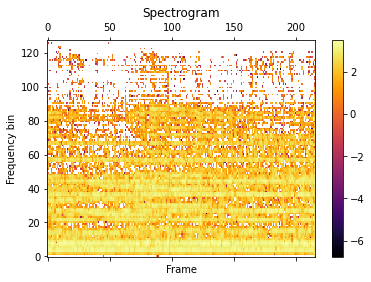

In [17]:
BATCH = 16
EPOCHS = 25
augment_prob = 0.5
fusion_type = 'concat'

# create a training dataset and dataloader
dataset = FMA2D(train, wf_transforms=[add_noise, gain], sp_transforms=[frequency_mask, time_mask], augment_prob=augment_prob)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH, shuffle=True)

# create a validation dataset and dataloader
val_dataset = FMA2D(val, augment_prob=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH, shuffle=True)

# define the loss function and the optimizer
if fusion_type == 'concat':
    loss_fn = nn.CrossEntropyLoss()
elif fusion_type == 'weighted':
    loss_fn = nn.NLLLoss()


# Lee 2017
# SGD optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)


for wf, spec, label in dataloader:
    plot_spectrogram(spec[0][0])
    break

p_dropout = 0.3
model = SoundFusion(p_dropout=p_dropout, fusion=fusion_type, FN=16)
#saved_dict = torch.load('SoundFusion-XS_B4_E5_OAdam_LR0.0001_pDNone_A0.0_feb08_t1537_VAL0.33875_TRAIN0.34745535714285714_4.pt')
#model.load_state_dict(saved_dict)

model.to(device)
#summary(model, [(1, 110250), (1, 128, 216)])

# Adam optimizer01
lr = 0.001
optimizer = torch.optim.Adam(model.parameters())
optimizer_name = 'Adam'


timestamp = time.strftime("feb%d_t%H%M", time.gmtime())
model_name = f"{model.name}M_{fusion_type}_B{BATCH}_E{EPOCHS}_O{optimizer_name}_LR{lr}_pD{p_dropout}_A{augment_prob}_{timestamp}"

[1, 400 / 400 batches - 4.91 min]
Validation Accuracy: 0.3180 | Training Accuracy: 0.2565 | Validation Loss: 12.7273 | Training loss: 13.5850 
[2, 400 / 400 batches - 10.26 min]
Validation Accuracy: 0.3545 | Training Accuracy: 0.2957 | Validation Loss: 13.1625 | Training loss: 12.9249 
[3, 400 / 400 batches - 15.63 min]
Validation Accuracy: 0.3071 | Training Accuracy: 0.3211 | Validation Loss: 12.5675 | Training loss: 12.5783 
[4, 400 / 400 batches - 21.18 min]
Validation Accuracy: 0.3700 | Training Accuracy: 0.3454 | Validation Loss: 11.6637 | Training loss: 12.2360 
[5, 400 / 400 batches - 26.43 min]
Validation Accuracy: 0.3752 | Training Accuracy: 0.3576 | Validation Loss: 11.6307 | Training loss: 12.0509 
[6, 400 / 400 batches - 31.69 min]
Validation Accuracy: 0.3550 | Training Accuracy: 0.3660 | Validation Loss: 11.6784 | Training loss: 11.9438 
[7, 400 / 400 batches - 36.79 min]
Validation Accuracy: 0.4061 | Training Accuracy: 0.3717 | Validation Loss: 11.5617 | Training loss: 11

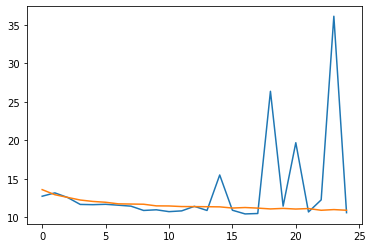

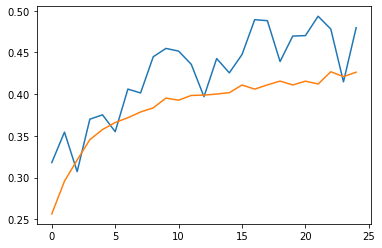

Finished Training


In [18]:

N_SUBSAMPLES = 7
num_epochs = EPOCHS
running_loss = 0.0
best_val_loss = float('inf') # initialize the best validation loss


t2 = time.time()

# train the model
acc_tr = []
acc_val = []
loss_tr = []
loss_val = []

epoch_len = len(dataset) // BATCH


for epoch in range(num_epochs):
    i = 0
    
    # evaluate the model on the training dataset
    train_correct = 0
    train_total = 0
    
    for wf_subsamples, spec_subsamples, label in dataloader:
        
        i += 1
        label = label.to(device)
        train_label = torch.argmax(label, dim=1)
        for idx in range(N_SUBSAMPLES):
            waveform = wf_subsamples[idx]
            spectrogram = spec_subsamples[idx]
    
            #t2 = time.time()
            # clear the gradients
            optimizer.zero_grad()
            waveform = waveform.to(device)
            spectrogram = spectrogram.to(device)
            # forward pass
            waveform = waveform.squeeze(0)  
            waveform = waveform.unsqueeze(1)
            spectrogram = spectrogram.squeeze(0)  
            spectrogram = spectrogram.unsqueeze(1)
            
            
            
            output = model(waveform, spectrogram)
            loss = loss_fn(output, train_label)

            # backward pass
            loss.backward()
            optimizer.step()  
            
            # Update the learning rate
            # scheduler.step(loss)
            
            _, train_predicted = torch.max(output.data, 1)
            train_total += train_label.size(0)
            train_correct += (train_predicted == train_label).sum().item()

            running_loss += loss.item()
            #print(t2 - time.time())
 
    tr_loss = running_loss / len(dataloader)
    loss_tr.append(tr_loss)
    tr_acc = train_correct / train_total 
    acc_tr.append(tr_acc)
    t1 = (time.time() - t2) / 60 
    #print(epoch + 1, i, epoch_len, t1, loss,  tr_acc)
    running_loss = 0            
    model.eval()
    # evaluate the model on the validation dataset
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for wf_subsamples, spec_subsamples, val_label in val_dataloader:
            val_label = val_label.to(device)
            val_label = torch.argmax(val_label, dim=1)
            for idx in range(N_SUBSAMPLES):
                waveform = wf_subsamples[idx]
                spectrogram = spec_subsamples[idx]
                waveform = waveform.to(device)
                spectrogram = spectrogram.to(device)
                waveform = waveform.squeeze(0)  
                waveform = waveform.unsqueeze(1)
                spectrogram = spectrogram.squeeze(0)  
                spectrogram = spectrogram.unsqueeze(1)
                val_output = model(waveform, spectrogram)
                val_loss += loss_fn(val_output, val_label).item()
                _, val_predicted = torch.max(val_output.data, 1)
                val_total += val_label.size(0)
                val_correct += (val_predicted == val_label).sum().item()


    loss = val_loss / len(val_dataloader)
    loss_val.append(loss)
    val_acc = val_correct / val_total
    acc_val.append(val_acc)
    # Save the model if the validation loss is the best seen so far
    if loss < best_val_loss:
        best_val_loss = loss
        best_val_acc = val_acc
        best_tr_acc = tr_acc
        best_state_dict = model.state_dict()
    print(f'[{epoch+1:d}, {i:d} / {epoch_len:d} batches - {t1:.2f} min]')
    print(f'Validation Accuracy: {val_acc:.4f} | Training Accuracy: {tr_acc:.4f}' + ' | Validation Loss: {:.4f} | Training loss: {:.4f} '.format(loss, tr_loss))  
    model.train()
                
plt.plot(loss_val, label='Validation loss')
plt.plot(loss_tr, label='Training loss')
plt.show()

plt.plot(acc_val, label='Validation accuracy')
plt.plot(acc_tr, label='Training accuracy')
plt.show()

torch.save(best_state_dict, model_name + f'_VAL{best_val_acc:.4f}_TRAIN{best_tr_acc:.4f}.pt')
print('Finished Training')

In [8]:
# in case we keyboard interrupt the training process we can save the best model manually:
model_name = model_name + f'_VAL{best_val_acc:.4f}_TRAIN{best_tr_acc:.4f}.pt'
torch.save(best_state_dict, model_name + f'_VAL{best_val_acc:.4f}_TRAIN{best_tr_acc:.4f}.pt')
print(model_name)
# model_name = "nnet1_2022-01-30_batchsize_32_epochs_100_opt_Adam_LR_0.0001_dropout1_acc0.373_subsampling"
# torch.save(model, model_name + '.pt')

SoundFusion-S_weighted_B16_E25_OAdam_LR0.0001_pD0.3_A0.5_feb10_t1703_VAL0.4832_TRAIN0.4240.pt


In [ ]:
# model_name = "ResNet_2022-01-23_batchsize_40_epochs_5_opt_Adam_LR_0.001"
# model_name = "nnet1_2022-01-25_batchsize_32_epochs_50_opt_Adam_LR_0.0001_acc_overfitted" #epoch15 overfit
# model_name = "nnet1_2022-01-30_batchsize_32_epochs_100_opt_Adam_LR_0.0001_dropout1_acc0.373_subsampling" # no overfit
# model_name = "ResNet_2022-01-23_batchsize_40_epochs_10_opt_Adam_LR_0.001"
torch.load(model_name+'.pt')

## Testing + aggregation + confusion matrix

In [19]:
N_SUBSAMPLES = 7
# create a dataset object for testing
test_dataset = FMA2D(val)
batch_size = 16
# create a data loader to load the dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#model = SoundFusion(FN=16, fusion='weighted', p_dropout=0.3)
#model_name= "SoundFusion-S_weighted_B16_E25_OAdam_LR0.0001_pD0.3_A0.5_feb10_t1703_VAL0.4832_TRAIN0.4240.pt"
#saved_dict = torch.load(model_name)
#model.load_state_dict(saved_dict)

# test the model
model.eval()
model.to(device)
correct = 0
correct_agg = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad(): # don't need to track, calculate or save the gradients in the model
    for wf_subsamples, spec_subsamples, labels in test_loader:
        labels = torch.argmax(labels, dim=1).cpu()
        batch_size = labels.size(0) # we reupdate the batch size because the last batch can be incomplete.
        subsample_outputs = {i: [] for i in range(batch_size)}
        for idx in range(N_SUBSAMPLES):
            waveform = wf_subsamples[idx]
            spectrogram = spec_subsamples[idx]
            waveform = waveform.to(device)
            spectrogram = spectrogram.to(device)
            waveform = waveform.squeeze(0)  
            waveform = waveform.unsqueeze(1)
            spectrogram = spectrogram.squeeze(0)  
            spectrogram = spectrogram.unsqueeze(1)
            outputs = model(waveform, spectrogram)
            predicted = torch.argmax(outputs.data, dim=1).cpu()
            
            for j in range(batch_size):
                subsample_outputs[j].append(predicted[j]) 
        for j in range(batch_size):
            # count the occurrences of each class
            counts = np.bincount(subsample_outputs[j])
            # Find the class with the highest count
            correct += np.sum([subsample_outputs[j][i] == labels[j] for i in range(N_SUBSAMPLES)])
            aggregate_prediction = np.argmax(counts)
            correct_agg += (aggregate_prediction == labels[j])
            all_preds.append(aggregate_prediction)
            all_labels.append(labels[j])

            
        total += labels.size(0)

print('Test accuracy without aggregation: %f %%' % (100/7 * correct / total))
print('Test accuracy with aggregation: %f %%' % (100 * correct_agg / total))

Test accuracy without aggregation: 47.964286 %
Test accuracy with aggregation: 51.625000 %


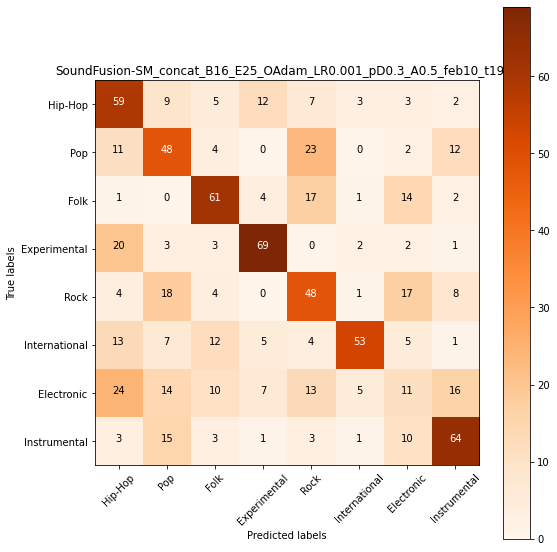

In [20]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):

     
    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    
    
from sklearn.metrics import confusion_matrix    
import itertools
# a tuple for all the class names
genre = tracks.track.genre_top.unique().to_list()
cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, genre, title=model_name)


In [ ]:
import os
import torch
import torchaudio

data_dir = './fma/data/fma_small'
output_dir = './fma/data/waveforms'
sampling_rate = 22_050

# create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
    
resample = torchaudio.transforms.Resample(44100, sampling_rate)
    
# loop through all MP3 files in the data directory
for root, dirs, files in os.walk(data_dir):
    for filename in files:
        if filename.endswith('.mp3'):
            filepath = os.path.join(root, filename)
            try: 
                waveform, sample_rate = torchaudio.load(filepath)
                waveform = stereo_to_mono(waveform) 

                # resample the waveform to the desired sample rate using the Resample transform
                waveform = resample(waveform)

                # save the spectrogram to the output directory
                output_file = os.path.join(output_dir, filename[:-4] + '.pt')
                torch.save(waveform, output_file)
            except:
                continue

## Remarks on implementations - draft

### There are two types of samples: mono and stereo - we need to convert mono to stereo when feeding the CNN

An audio channel refers to a single track of audio. The number of channels in an audio file determines the number of separate audio tracks that are mixed together to form the final audio.

A mono audio file has a single channel, which means that all the audio is mixed together into one single track. This means that if you play a mono audio file, the same audio will come out of both the left and right speakers (or headphones) and it will sound the same regardless of the stereo or mono setup.

A stereo audio file, on the other hand, has two channels - a left channel and a right channel. These two channels carry separate audio tracks that are mixed together to create the final audio. When played back on a stereo setup, each channel will be played through its corresponding speaker or headphone and this way, the stereo audio creates a sense of space and directionality.

So, for example, a stereo audio recording of a live concert will have different audio captured by different microphone positioned in different positions in the concert hall, and when it is played back, it creates the sense of being there in the concert hall.

It is worth noting that there are also audio file format with more than 2 channels, such as 5.1 or 7.1 surround sound audio.


### Downsampling

 we downsample the audio signals to a lower sample rate to reduce the data size or to simplify the processing of the signal. Downsampling can be useful for tasks such as speech recognition or audio classification, where the lower frequencies of the signal are more important than the higher frequencies.

## One batch check

In [ ]:
BATCH = 1

# create a training dataset and dataloader
dataset = FMA2D(train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH, shuffle=True)



# create a validation dataset and dataloader
val_dataset = FMA2D(val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH, shuffle=True)

    
# create the CNN model
model = nnet1(num_classes=8) # HERE YOU PUT UR NETWORK
model.to(device)

# define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()

# Adam optimizer
#optimizer = torch.optim.Adam(model.parameters())


# Lee 2017
# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

# Define the scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)



num_epochs = 10
i = 0
running_loss = 0.0

import time
    
# train the model
acc_tr = []
acc_val = []
loss_tr = []
loss_val = []

spectrogram, label = next(iter(dataloader))
spectrogram = spectrogram.squeeze(-1)  
spectrogram = spectrogram.unsqueeze(0)

for epoch in range(num_epochs):
            # evaluate the model on the training dataset
            train_correct = 0
            train_total = 0
    #for spectrogram, label in dataloader:
            
            label = label.to(device)
            train_label = torch.argmax(label, dim=1)


            # forward pass
#             spectrogram = spectrogram.squeeze(-1)  
#             spectrogram = spectrogram.unsqueeze(0)
            
            spectrogram = spectrogram.to(device)
            output = model(spectrogram)
            print(spectrogram.size())
            loss = loss_fn(output, label)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()  
            
            # Update the learning rate
            scheduler.step(loss)
            
            _, train_predicted = torch.max(output.data, 1)
            train_total += train_label.size(0)
            train_correct += (train_predicted == train_label).sum().item()
            # print statistics
            i += 1
            running_loss += loss.item()
            print(train_correct)
            
            
            
#     loss = running_loss / len(dataloader)
#     loss_tr.append(loss)
#     print('[%d, %5d subsamples] Training loss: %.3f' % (epoch + 1, i*BATCH, loss))
#     running_loss = 0            
#     # evaluate the model on the validation dataset
#     val_loss = 0.0
#     val_correct = 0
#     val_total = 0
#     with torch.no_grad():
#         for val_spectrogram, val_label in val_dataloader:
#                 val_label = val_label.to(device)
#                 val_label = torch.argmax(val_label, dim=1)
            
#                 val_spectrogram = val_spectrogram.squeeze(-1)
#                 val_spectrogram = val_spectrogram.unsqueeze(0)
#                 val_spectrogram = val_spectrogram.to(device)
#                 val_output = model(val_spectrogram)
#                 val_loss += loss_fn(val_output, val_label).item()
#                 _, val_predicted = torch.max(val_output.data, 1)
#                 val_total += val_label.size(0)
#                 val_correct += (val_predicted == val_label).sum().item()

#     loss = val_loss / len(val_dataloader)
#     loss_val.append(loss)
#     val_acc = val_correct / val_total
#     tr_acc = train_correct / train_total 
#     acc_tr.append(tr_acc)
#     acc_val.append(val_acc)
#     print('Validation Loss: {:.4f} | Validation Accuracy: {:.4f} | Training Accuracy: {:.4f}'.format(loss, val_acc, tr_acc))

plt.plot(loss_val, label='Validation loss')
plt.plot(loss_tr, label='Training loss')
plt.show()

plt.plot(acc_val, label='Validation accuracy')
plt.plot(acc_tr, label='Training accuracy')
plt.show()
    
print('Finished Training')